# 预读取

In [29]:
import h5py
import cv2
import warp_norm
import matplotlib
# import sys
# sys.path.append("./FaceAlignment")
# import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import gaze_network
from torchvision import transforms
import pickle
import pandas as pd
import copy
import os
from pt_module import StNet,StRefine
from ipdb import set_trace as st


In [68]:
colors = plt.cm.viridis(np.linspace(0, 1, 4))
model_dir = './ckpt'
state_name = 'spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt'
state_path = os.path.join(model_dir,state_name)
condition_label=['glass && upright tan','glass && upright chen',
                 'no glass && upright tan','no glass && upright chen',
                 'glass && not upright tan','glass && not upright chen',
                 'no glass && not upright tan','no glass && not upright chen',
                 'glass && indoor daylight tan', 'glass && indoor daylight chen',
                 'no glass && indoor daylight tan','no glass && indoor daylight chen',
                 'glass && only lamp tan','glass && only lamp chen',
                 'no glass && only lamp tan','no glass && only lamp chen',
                 'glass && only external lighting tan','glass && only external lighting chen',
                 'no glass && only external lighting tan','no glass && only external lighting chen',
                 'mask tan','mask chen',
                 'Normal indoor lighting at night && glass && no mask tan', 'Normal indoor lighting at night && glass && no mask chen',
                 'Normal indoor lighting at night && glass && large camera distance(70cm+) tan','Normal indoor lighting at night && glass && large camera distance(70cm+) chen',
                 'Normal indoor lighting at night && glass && middle camera distance(45-48cm) tan','Normal indoor lighting at night && glass && middle camera distance(45-48cm) chen',
                 'Normal indoor lighting at night && glass && small camera distance(32-35cm) tan','Normal indoor lighting at night && glass && small camera distance(32-35cm) chen',
                 'Normal indoor lighting at night && glass && large inclination angle(45°) tan','Normal indoor lighting at night && glass && large inclination angle(45°) chen',
                 'Normal indoor lighting at night && glass && middle inclination angle(30°) tan','Normal indoor lighting at night && glass && middle inclination angle(30°) chen',
                 'Normal indoor lighting at night && glass && small inclination angle(15°) tan','Normal indoor lighting at night && glass && small inclination angle(15°) chen',
                 'Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone chen',
                 'Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone chen',
                 'Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the phone chen']
print(len(condition_label))

48


In [31]:
# 读取数据
with open('/home/hgh/hghData/all_3_5.pkl', 'rb') as fo:
    datalist = pickle.load(fo, encoding='bytes')#que
with open('/home/hgh/hghData/gaze_pred_3_5.pkl', 'rb') as fo:
    predlist = pickle.load(fo, encoding='bytes')#que

In [32]:
# 提取datapath和pred
# print(predlist)
file_dict = []
preds = []
for pred in predlist:
    file_dict.append(int(os.path.splitext(os.path.basename(pred['org_data']))[0]))
    preds.append(pred['pred'])
preds = np.asarray(preds).reshape((-1,2))

print(file_dict)
print(preds)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [33]:
def get_condition_number(file_dict):
    if (1 <= file_dict <= 100):
        return 0
    if (101 <= file_dict <= 200):
        return 1
    if (201 <= file_dict <= 300):
        return 2
    if (301 <= file_dict <= 400):
        return 3
    if (401 <= file_dict <= 500):
        return 4
    if (501 <= file_dict <= 600):
        return 5
    if (601 <= file_dict <= 700):
        return 6
    if (701 <= file_dict <= 800):
        return 7
    if (801 <= file_dict <= 850):
        return 8
    if (851 <= file_dict <= 900):
        return 9
    if (901 <= file_dict <= 950):
        return 10
    if (951 <= file_dict <= 1000):
        return 11
    if (1001 <= file_dict <= 1050):
        return 12
    if (1051 <= file_dict <= 1100):
        return 13
    if (1101 <= file_dict <= 1150):
        return 14
    if (1151 <= file_dict <= 1200):
        return 15
    if (1201 <= file_dict <= 1250):
        return 16
    if (1251 <= file_dict <= 1300):
        return 17
    if (1301 <= file_dict <= 1350):
        return 18
    if (1351 <= file_dict <= 1400):
        return 19
    if (1401 <= file_dict <= 1420):
        return 20
    if (1421 <= file_dict <= 1440):
        return 21
    if (1441 <= file_dict <= 1520):
        return 22
    if (1521 <= file_dict <= 1600):
        return 23
    if (1601 <= file_dict <= 1620):
        return 24
    if (1621 <= file_dict <= 1640):
        return 25
    if (1641 <= file_dict <= 1700):
        return 26
    if (1701 <= file_dict <= 1760):
        return 27
    if (1761 <= file_dict <= 1780):
        return 28
    if (1781 <= file_dict <= 1800):
        return 29
    if (1801 <= file_dict <= 1820):
        return 30
    if (1821 <= file_dict <= 1840):
        return 31
    if (1841 <= file_dict <= 1900):
        return 32
    if (1901 <= file_dict <= 1960):
        return 33
    if (1961 <= file_dict <= 1980):
        return 34
    if (1981 <= file_dict <= 2000):
        return 35
    if (2001 <= file_dict <= 2050):
        return 36
    if (2051 <= file_dict <= 2100):
        return 37
    if (2101 <= file_dict <= 2150):
        return 38
    if (2151 <= file_dict <= 2200):
        return 39
    if (2201 <= file_dict <= 2250):
        return 40
    if (2251 <= file_dict <= 2300):
        return 41
    if (2301 <= file_dict <= 2350):
        return 42
    if (2351 <= file_dict <= 2400):
        return 43
    if (2401 <= file_dict <= 2450):
        return 44
    if (2451 <= file_dict <= 2500):
        return 45
    if (2501 <= file_dict <= 2550):
        return 46
    if (2551 <= file_dict <= 2600):
        return 47

In [34]:
data_dict = {}
pred_dict = {}
for filename, data, pred in zip(file_dict, datalist, predlist):
    condition = get_condition_number(filename)

    if condition not in data_dict:
        data_dict[condition] = []
        pred_dict[condition] = []
        
    data_dict[condition].append(data)
    pred_dict[condition].append(pred['pred'])

for i in range(len(pred_dict)):
    pred_dict[i] = np.vstack(pred_dict[i])
for condition, data_list in data_dict.items():
    print(f"Condition {condition}: {data_list}")
#print(pred_dict[0].shape)

Condition 0: [<gaze_normalize.GazeNormalize object at 0x7fa05137bc10>, <gaze_normalize.GazeNormalize object at 0x7fa05137b370>, <gaze_normalize.GazeNormalize object at 0x7fa05168b160>, <gaze_normalize.GazeNormalize object at 0x7fa0514da8e0>, <gaze_normalize.GazeNormalize object at 0x7fa0515c2ac0>, <gaze_normalize.GazeNormalize object at 0x7fa051581eb0>, <gaze_normalize.GazeNormalize object at 0x7fa051581940>, <gaze_normalize.GazeNormalize object at 0x7fa051581040>, <gaze_normalize.GazeNormalize object at 0x7fa051581df0>, <gaze_normalize.GazeNormalize object at 0x7fa051581340>, <gaze_normalize.GazeNormalize object at 0x7fa051581be0>, <gaze_normalize.GazeNormalize object at 0x7fa0517e4280>, <gaze_normalize.GazeNormalize object at 0x7fa05137b310>, <gaze_normalize.GazeNormalize object at 0x7fa05137ba90>, <gaze_normalize.GazeNormalize object at 0x7fa05137b0a0>, <gaze_normalize.GazeNormalize object at 0x7fa05137b190>, <gaze_normalize.GazeNormalize object at 0x7fa05137b4f0>, <gaze_normalize.G

In [35]:
# 将pitchyaw转换成vector
for i in range(len(pred_dict)):
    pred_dict[i] = warp_norm.pitchyaw_to_vector(pred_dict[i])

In [36]:
ground_truth = {}
pred = {}
RMat = {}
face_center = {}
for i in range(len(file_dict)):
    # st()
    number = get_condition_number(file_dict[i])
    if number not in ground_truth:
        ground_truth[number] = []
        pred[number] = []
        RMat[number] = []
        face_center[number] = []
    ground_truth[number].append(datalist[i].label)
    pred[number].append(preds[i])
    RMat[number].append(datalist[i].R)
    face_center[number].append(datalist[i].face_center)
for i in range(len(ground_truth)):
    ground_truth[i] = np.vstack(ground_truth[i])
    pred[i] = np.vstack(pred[i])
# 将pitchyaw转换成vector
for i in range(len(ground_truth)):
    pred[i] = warp_norm.pitchyaw_to_vector(pred[i])

# 还原注视向量并获取投影点

In [40]:
epi = 1
# 将归一化向量还原
org_pred = {}
pred_gc = {}
for i in range(len(ground_truth)):
    for j in range(len(RMat[i])):
        # print(RMat[i][j])
        RMat[i][j][2] *= epi
        if i not in org_pred:
            org_pred[i] = []
            pred_gc[i] = []
        org_pred[i].append(np.dot(np.linalg.inv(RMat[i][j]), pred[i][j].T))


In [41]:
pixel_scale_tan = np.array([0.202, 0.224])
pixel_scale_chen = np.array([0.22, 0.235])

for i in range(len(ground_truth)):
    for j in range(len(pred[i])):
        if i%2 == 0:
            pred_gc[i].append(warp_norm.vector_to_gc(org_pred[i][j], pixel_scale_tan, face_center=-face_center[i][j][2,0]))
        else:
            pred_gc[i].append(warp_norm.vector_to_gc(org_pred[i][j], pixel_scale_chen, face_center=-face_center[i][j][2,0]))
# print(pred_gc[0])

In [42]:
org_tan = np.array([800,0])#tan 1600*825
org_chen = np.array([650,0])#chen 1300*720


pred_gc_org = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    if i%2 == 0:
        pred_gc_org[i] = org_tan + pred_gc[i]
    else:
        pred_gc_org[i] = org_chen + pred_gc[i]

In [43]:
# calculate standard deviation distance
l2 = []
for i in range(8):
    l2.append(np.mean(np.linalg.norm(ground_truth[i]-pred_gc_org[i],axis = 1)))
print(l2)
print(np.mean(l2[:4]))

[204.70738402795251, 172.60175022685763, 323.8679897326241, 236.7311647498675, 492.93265195785006, 276.0002746507235, 468.31602860703185, 301.84280959479423]
234.47707218432544


In [44]:
pred_errors=[]
pred_xerrors=[]
pred_yerrors=[]
for i in range(46):
    total_errors=0
    total_xerrors = 0
    total_yerrors = 0
    for j in range(len(pred[i])):
        total_errors=total_errors+((pred_gc_org[i][j][0]-ground_truth[i][j][0])**2+(pred_gc_org[i][j][1]-ground_truth[i][j][1])**2)**0.5
        total_xerrors=total_xerrors+abs(pred_gc_org[i][j][0]-ground_truth[i][j][0])
        total_yerrors = total_yerrors + abs(pred_gc_org[i][j][1] - ground_truth[i][j][1])
    pred_errors.append(total_errors/(len(pred[i])))
    pred_xerrors.append(total_xerrors / (len(pred[i])))
    pred_yerrors.append(total_yerrors / (len(pred[i])))
pred_xerrors_cm=[]
pred_yerrors_cm=[]
for i in range(46):
    if i % 2 == 0:
        pred_xerrors_cm.append(pred_xerrors[i] * 0.1 * pixel_scale_tan[0])
        pred_yerrors_cm.append(pred_yerrors[i] * 0.1 * pixel_scale_tan[1])
    else:
        pred_xerrors_cm.append(pred_xerrors[i] * 0.1 * pixel_scale_chen[0])
        pred_yerrors_cm.append(pred_yerrors[i] * 0.1 * pixel_scale_chen[1])
# print(pred_errors)
print('pred errors:')
print(pred_xerrors_cm)
print(pred_yerrors_cm)


pred errors:
[2.645480183176489, 2.7830286783696145, 1.4901423461804515, 2.2081110992096726, 8.173843892473613, 3.9077396791889063, 6.604823098771231, 3.171703902489755, 4.195686845317218, 14.396684063104543, 3.019193728792992, 6.519646829128913, 13.800275953302814, 7.791775431130467, 2.3015922725061477, 3.648412278558224, 9.601305423006352, 3.5089403278673976, 3.2864656645841244, 3.318441462773007, 14.410006849472103, 9.08430523140587, 5.336084894422473, 7.164290113556234, 6.169697083970425, 7.752790686155082, 7.566396269554602, 5.688832153711648, 2.9393474100291206, 3.932392540991004, 4.307251993916608, 9.106387857876816, 11.250743918372745, 5.045361889688935, 8.758700987414596, 4.75182569409877, 5.3640353498399325, 6.219619226147532, 22.754308008873416, 15.105013530746062, 4.861274698485405, 4.917077426655471, 21.301501284844818, 19.74643585317083, 2.6833760401283513, 5.52404725537494]
[2.9816698123830667, 2.2935091671126835, 6.968510232307627, 4.729878531496716, 4.643485515839675, 

In [45]:
in_screen_net = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(len(pred[i])):
        if i%2==0:#tan
            if (0 - 0.05 * 1600 <= pred_gc_org[i][j][0] <= 1600 + 0.05 * 1600 and 0 - 0.05 * 825 <= pred_gc_org[i][j][1] <= 825 + 0.05 * 825):
                in_screen_net[i].append(1)
            else:
                in_screen_net[i].append(0)
        else:
            if (0 - 0.05 * 1300 <= pred_gc_org[i][j][0] <= 1300 + 0.05 * 1300 and 0 - 0.05 * 720 <= pred_gc_org[i][j][1] <= 720 + 0.05 * 720):
                in_screen_net[i].append(1)
            else:
                in_screen_net[i].append(0)
# print(in_screen)

device_level_accuracy=[]
for i in range(46):
    total_in=0
    for j in range(len(pred[i])):
        total_in=total_in+in_screen_net[i][j]
    device_level_accuracy.append(total_in/len(pred[i]))
    if(i==36 or i==37 or i==40 or i==41 or i==44 or i==45):
        device_level_accuracy[i]=1-device_level_accuracy[i]
print(device_level_accuracy)

[0.98, 0.86, 0.69, 0.74, 0.68, 0.74, 0.81, 0.76, 0.92, 0.58, 0.88, 0.5, 0.42, 0.32, 0.76, 0.86, 0.96, 0.88, 0.64, 0.6, 0.6, 0.6842105263157895, 1.0, 0.7125, 1.0, 0.65, 1.0, 0.75, 1.0, 0.8, 0.0, 0.65, 0.016666666666666666, 0.8, 0.9, 0.9, 0.12, 0.14, 0.86, 0.76, 0.16000000000000003, 0.26, 0.86, 0.76, 0.040000000000000036, 0.24]


# 使用sc模块处理

In [46]:
# SC Module
gtr=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
aver_pred=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
offset=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    total_truth=[0,0]
    total_pred=[0,0]
    for j in range(int(len(pred[i])/2)):
        total_truth=total_truth + ground_truth[i][j]
        total_pred = total_pred + pred_gc_org[i][j]
    if i%2==0:
        gtr[i] = [800, 412.5]
    else:
        gtr[i] = [650, 360]
    aver_pred[i] = total_pred / int(len(pred[i])/2)
    if i < 8:
        print(aver_pred)
        offset[i] = aver_pred[i % 4] - gtr[i]
    elif 8 <= i < 20:
        offset[i] = aver_pred[i] - gtr[i]
    else:
        offset[i] = aver_pred[20+i%2] - gtr[i]

[array([812.50866925, 312.84050891]), [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[array([812.50866925, 312.84050891]), array([570.05546938, 420.08482386]), [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[array([812.50866925, 312.84050891]), array([570.05546938, 420.08482386]), array([590.51881603, 779.88018875]), [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[array([812.50866925, 312.84050891]), array([570.05546938, 420.08482386]), array([590.51881603, 779.88018875]), array([623.66833831, 585.93240527]), [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

In [48]:
refine_pred=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    refine_pred[i]=pred_gc_org[i] - offset[i]


In [49]:
SC_errors=[]
SC_xerrors=[]
SC_yerrors=[]
for i in range(46):
    total_errors = 0
    total_xerrors = 0
    total_yerrors = 0
    for j in range(len(pred[i])):
        total_errors=total_errors+((refine_pred[i][j][0]-ground_truth[i][j][0])**2+(refine_pred[i][j][1]-ground_truth[i][j][1])**2)**0.5
        total_xerrors = total_xerrors + abs(refine_pred[i][j][0] - ground_truth[i][j][0])
        total_yerrors = total_yerrors + abs(refine_pred[i][j][1] - ground_truth[i][j][1])
    SC_errors.append(total_errors/len(pred[i]))
    SC_xerrors.append(total_xerrors / len(pred[i]))
    SC_yerrors.append(total_yerrors / len(pred[i]))
SC_xerrors_cm=[]
SC_yerrors_cm=[]
for i in range(46):
    if i % 2 == 0:
        SC_xerrors_cm.append(SC_xerrors[i] * 0.1 * pixel_scale_tan[0])
        SC_yerrors_cm.append(SC_yerrors[i] * 0.1 * pixel_scale_tan[1])
    else:
        SC_xerrors_cm.append(SC_xerrors[i] * 0.1 * pixel_scale_chen[0])
        SC_yerrors_cm.append(SC_yerrors[i] * 0.1 * pixel_scale_chen[1])
print('SC errors:')
# print(SC_errors_cm)
print(SC_xerrors_cm)
print(SC_yerrors_cm)


SC errors:
[2.8201754754264017, 2.195707218448522, 3.1035594613398496, 2.283464706074623, 8.274913940043978, 2.9666568338328863, 7.510786678007073, 3.404896510361645, 3.2993470181785725, 4.988978676967146, 2.771831667999931, 2.7583680409468503, 10.177675688101731, 7.5648719697688955, 2.490793489279892, 3.390203939791566, 9.650464254534786, 2.5581582415050987, 3.625309045595053, 2.5831220877058305, 11.720204031173033, 6.1725939571725545, 6.870000784322341, 4.975091513281191, 8.535048476906821, 5.728303359989492, 7.544653417374303, 3.638078945087051, 8.01310186317332, 1.6315647865039011, 6.2847930540707795, 6.7582533303390235, 6.644913362758564, 3.0714260371323387, 8.089581714243616, 2.86973530116631, 8.610240085444428, 3.9908030413525215, 29.075753891420536, 13.791913080358118, 5.615198496846006, 2.972750953712526, 27.622947167391946, 16.809519559822213, 7.467177752368016, 3.224570973650046]
[2.9996373408097186, 2.050826052618557, 2.0215093177572676, 1.4361069134468598, 6.36750598180240

In [50]:
in_screen_SC = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(len(pred[i])):
        if i%2==0:#tan
            if (0 - 0.05 * 1600 <= refine_pred[i][j][0] <= 1600 + 0.05 * 1600 and 0 - 0.05 * 825 <= refine_pred[i][j][1] <= 825 + 0.05 * 825):
                in_screen_SC[i].append(1)
            else:
                in_screen_SC[i].append(0)
        else:
            if (0 - 0.05 * 1300 <= refine_pred[i][j][0] <= 1300 + 0.05 * 1300 and 0 - 0.05 * 720 <= refine_pred[i][j][1] <= 720 + 0.05 * 720):
                in_screen_SC[i].append(1)
            else:
                in_screen_SC[i].append(0)
# print(in_screen)


In [51]:
device_level_accuracy=[]
for i in range(46):
    total_in=0
    for j in range(len(pred[i])):
        total_in=total_in+in_screen_SC[i][j]
    device_level_accuracy.append(total_in/len(pred[i]))
    if(i==36 or i==37 or i==40 or i==41 or i==44 or i==45):
        device_level_accuracy[i]=1-device_level_accuracy[i]
print(device_level_accuracy)

[0.99, 0.93, 0.91, 0.89, 0.53, 0.78, 0.84, 0.72, 1.0, 0.92, 0.96, 0.9, 0.96, 1.0, 0.86, 0.8, 1.0, 0.9, 0.82, 0.84, 0.8, 0.7368421052631579, 0.825, 0.7, 0.6, 0.6, 0.8833333333333333, 0.7333333333333333, 0.85, 0.75, 0.0, 0.65, 0.0, 0.9166666666666666, 0.15, 0.85, 0.21999999999999997, 0.06000000000000005, 0.94, 0.7, 0.09999999999999998, 0.24, 0.98, 0.74, 0.30000000000000004, 0.26]


# 使用st模块处理

In [52]:
history=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(int(len(refine_pred[i]) / 2)):
        history[i].append(np.array(refine_pred[i][j]))
    # print(np.array(history[i]))
# create_history_gaze_path_map(history[0])

In [53]:
#PT Module
st_refine_tan = StRefine(StNet_path=state_path, full_screen_size=(1600, 825))
st_refine_chen = StRefine(StNet_path=state_path, full_screen_size=(1300, 720))
# result,valid=st_refine.refine(np.array(refine_pred[0][0]),history[0])
# print(refine_pred[0][0])
# print(result.detach().cpu().numpy())

StRefine loaded from ./ckpt/spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt ---jfejoij st_refine_net.py
StRefine loaded from ./ckpt/spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt ---jfejoij st_refine_net.py


In [54]:
final_pred=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(len(refine_pred[i])):
        if i < 20:
            if i % 2 == 0:
                output, valid = st_refine_tan.refine(np.array(refine_pred[i][j]), np.array(history[i % 4]))
            else:
                output, valid = st_refine_chen.refine(np.array(refine_pred[i][j]), np.array(history[i % 4]))
        else:
            if i % 2 == 0:
                output, valid = st_refine_tan.refine(np.array(refine_pred[i][j]), np.array(history[i % 2]))
            else:
                output, valid = st_refine_chen.refine(np.array(refine_pred[i][j]), np.array(history[i % 2]))

        # if(i==2 or i==3):
        #     output, valid = st_refine.refine(np.array(refine_pred[i][j]), np.array(history[i-2]))
        # else:
        #     output, valid = st_refine.refine(np.array(refine_pred[i][j]), np.array(history[i]))
        # print(refine_pred[i][j],output,valid)
        # print(output.detach().cpu().numpy())
        if valid:
            final_pred[i].append(output.detach().cpu().numpy())
        else:
            final_pred[i].append(output)
    # print(np.array(final_pred[i]).shape)


/home/hgh/anaconda3/envs/gazeE/lib/python3.8/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/hgh/anaconda3/envs/gazeE/lib/python3.8/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [55]:
aver_pred=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

for i in range(46):
    total_xy=[0,0]
    for j in range(len(pred[i])):
        total_xy=total_xy+final_pred[i][j]
    aver_pred[i]=total_xy/len(pred[i])
# print(aver_pred)

In [56]:
PT_errors=[]
PT_xerrors=[]
PT_yerrors=[]
for i in range(46):
    total_errors = 0
    total_xerrors = 0
    total_yerrors = 0

    for j in range(len(pred[i])):
        total_errors=total_errors+((final_pred[i][j][0]-ground_truth[i][j][0])**2+(final_pred[i][j][1]-ground_truth[i][j][1])**2)**0.5
        total_xerrors = total_xerrors +abs(final_pred[i][j][0] - ground_truth[i][j][0])
        total_yerrors = total_yerrors + abs(final_pred[i][j][1] - ground_truth[i][j][1])
    PT_errors.append(total_errors/len(pred[i]))
    PT_xerrors.append(total_xerrors / len(pred[i]))
    PT_yerrors.append(total_yerrors / len(pred[i]))

PT_xerrors_cm=[]
PT_yerrors_cm=[]
for i in range(46):
    if i % 2 == 0:
        PT_xerrors_cm.append(PT_xerrors[i] * 0.1*pixel_scale_tan[0])
        PT_yerrors_cm.append(PT_yerrors[i] * 0.1*pixel_scale_tan[1])
    else:
        PT_xerrors_cm.append(PT_xerrors[i] * 0.1*pixel_scale_chen[0])
        PT_yerrors_cm.append(PT_yerrors[i] * 0.1*pixel_scale_chen[1])
print('PT errors:')
# print(PT_magnify_errors_cm)
print(PT_xerrors_cm)
print(PT_yerrors_cm)


PT errors:
[2.0742141156875284, 2.259566485660909, 2.8698970256366794, 2.3693578911527475, 8.135043255527815, 2.996194170520597, 7.657059473864, 3.4356173531729537, 2.930783460021973, 4.984416498005221, 2.595770881473532, 2.6462751724604012, 10.551952078341406, 7.627019494222201, 2.606455725023454, 3.321830194252231, 10.016046885226753, 2.60506492957696, 3.7094981862272682, 2.855999338771455, 11.84732973286921, 6.155240010981057, 7.341352378988784, 4.97488673484069, 8.827402925817681, 5.738640372432865, 7.625562715708796, 3.629585087925889, 8.421352473679981, 1.5916887624515763, 6.2847930540707795, 6.777888089001435, 6.644913362758564, 3.140926197780046, 8.102601399528659, 2.9321739934296174, 9.219909887211395, 4.04979121259339, 29.807594156341562, 13.883614843454772, 6.3035998328984535, 2.996852563268868, 29.287145722166215, 16.886255498489398, 8.027475773561804, 3.223398748390697]
[2.8900883280873626, 1.9787452987291747, 2.0181721904870016, 1.4550389625109146, 6.9036061161384294, 3.5

In [57]:
in_screen_PT = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(46):
    for j in range(len(pred[i])):
        if i%2==0:#tan
            if (0 - 0.05 * 1600 <= final_pred[i][j][0] <= 1600 + 0.05 * 1600 and 0 - 0.05 * 825 <= final_pred[i][j][1] <= 825 + 0.05 * 825):
                in_screen_PT[i].append(1)
            else:
                in_screen_PT[i].append(0)
        else:
            if (0 - 0.05 * 1300 <= final_pred[i][j][0] <= 1300 + 0.05 * 1300 and 0 - 0.05 * 720 <= final_pred[i][j][1] <= 720 + 0.05 * 720):
                in_screen_PT[i].append(1)
            else:
                in_screen_PT[i].append(0)
# print(in_screen)
device_level_accuracy=[]
for i in range(46):
    total_in=0
    for j in range(len(pred[i])):
        total_in=total_in+in_screen_PT[i][j]
    device_level_accuracy.append(total_in/len(pred[i]))
    if(i==36 or i==37 or i==40 or i==41 or i==44 or i==45):
        device_level_accuracy[i]=1-device_level_accuracy[i]
print(device_level_accuracy)

[0.99, 0.93, 0.91, 0.89, 0.53, 0.78, 0.84, 0.72, 1.0, 0.92, 0.96, 0.9, 0.96, 1.0, 0.86, 0.8, 1.0, 0.9, 0.82, 0.84, 0.8, 0.7368421052631579, 0.825, 0.7, 0.6, 0.6, 0.8833333333333333, 0.7333333333333333, 0.85, 0.75, 0.0, 0.65, 0.0, 0.9166666666666666, 0.15, 0.85, 0.21999999999999997, 0.06000000000000005, 0.94, 0.7, 0.09999999999999998, 0.24, 0.98, 0.74, 0.30000000000000004, 0.26]


# magnifiy（revoke）

In [58]:
# for i in range(46):
#     for j in range(len(pred[i])):
#         if i % 2 == 0:
#             final_pred[i][j] = pixel_scale_tan / 2 + (final_pred[i][j] - pixel_scale_tan / 2)/0.7
#         else:
#             final_pred[i][j] = pixel_scale_chen / 2 + (final_pred[i][j] - pixel_scale_chen / 2)/0.7

In [59]:
# PT_magnify_errors=[]
# PT_magnify_xerrors=[]
# PT_magnify_yerrors=[]
# for i in range(46):
#     total_errors = 0
#     total_xerrors = 0
#     total_yerrors = 0

#     for j in range(len(pred[i])):
#         total_errors=total_errors+((final_pred[i][j][0]-ground_truth[i][j][0])**2+(final_pred[i][j][1]-ground_truth[i][j][1])**2)**0.5
#         total_xerrors = total_xerrors +abs(final_pred[i][j][0] - ground_truth[i][j][0])
#         total_yerrors = total_yerrors + abs(final_pred[i][j][1] - ground_truth[i][j][1])
#     PT_magnify_errors.append(total_errors/len(pred[i]))
#     PT_magnify_xerrors.append(total_xerrors / len(pred[i]))
#     PT_magnify_yerrors.append(total_yerrors / len(pred[i]))

# PT_magnify_xerrors_cm=[]
# PT_magnify_yerrors_cm=[]
# for i in range(46):
#     if i % 2 == 0:
#         PT_magnify_xerrors_cm.append(PT_magnify_xerrors[i] * 0.1*pixel_scale_tan[0])
#         PT_magnify_yerrors_cm.append(PT_magnify_yerrors[i] * 0.1*pixel_scale_tan[1])
#     else:
#         PT_magnify_xerrors_cm.append(PT_magnify_xerrors[i] * 0.1*pixel_scale_chen[0])
#         PT_magnify_yerrors_cm.append(PT_magnify_yerrors[i] * 0.1*pixel_scale_chen[1])
# print('PT errors:')
# # print(PT_magnify_errors_cm)
# print(PT_magnify_xerrors_cm)
# print(PT_magnify_yerrors_cm)


In [60]:
# in_screen_PT = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
# for i in range(46):
#     for j in range(len(pred[i])):
#         if i%2==0:#tan
#             if (0 - 0.05 * 1600 <= final_pred[i][j][0] <= 1600 + 0.05 * 1600 and 0 - 0.05 * 825 <= final_pred[i][j][1] <= 825 + 0.05 * 825):
#                 in_screen_PT[i].append(1)
#             else:
#                 in_screen_PT[i].append(0)
#         else:
#             if (0 - 0.05 * 1300 <= final_pred[i][j][0] <= 1300 + 0.05 * 1300 and 0 - 0.05 * 720 <= final_pred[i][j][1] <= 720 + 0.05 * 720):
#                 in_screen_PT[i].append(1)
#             else:
#                 in_screen_PT[i].append(0)
# # print(in_screen)

In [61]:
# device_level_accuracy=[]
# for i in range(46):
#     total_in=0
#     for j in range(len(pred[i])):
#         total_in=total_in+in_screen_PT[i][j]
#     device_level_accuracy.append(total_in/len(pred[i]))
#     if(i==36 or i==37 or i==40 or i==41 or i==44 or i==45):
#         device_level_accuracy[i]=1-device_level_accuracy[i]
# print(device_level_accuracy)

# 展示

In [69]:
import pandas as pd
data = {
    'pred_xerrors_cm':pred_xerrors_cm,
    'pred_yerrors_cm':pred_yerrors_cm,
    'SC_xerrors_cm':SC_xerrors_cm,
    'SC_yerrors_cm':SC_yerrors_cm,
    'PT_xerrors_cm':PT_xerrors_cm,
    'PT_yerrors_cm':PT_yerrors_cm,
    'device_level_accuracy':device_level_accuracy
}
df = pd.DataFrame(data)
df.to_excel('./new_example.xlsx', index=False)



377.51836423094994
602.8520644453254


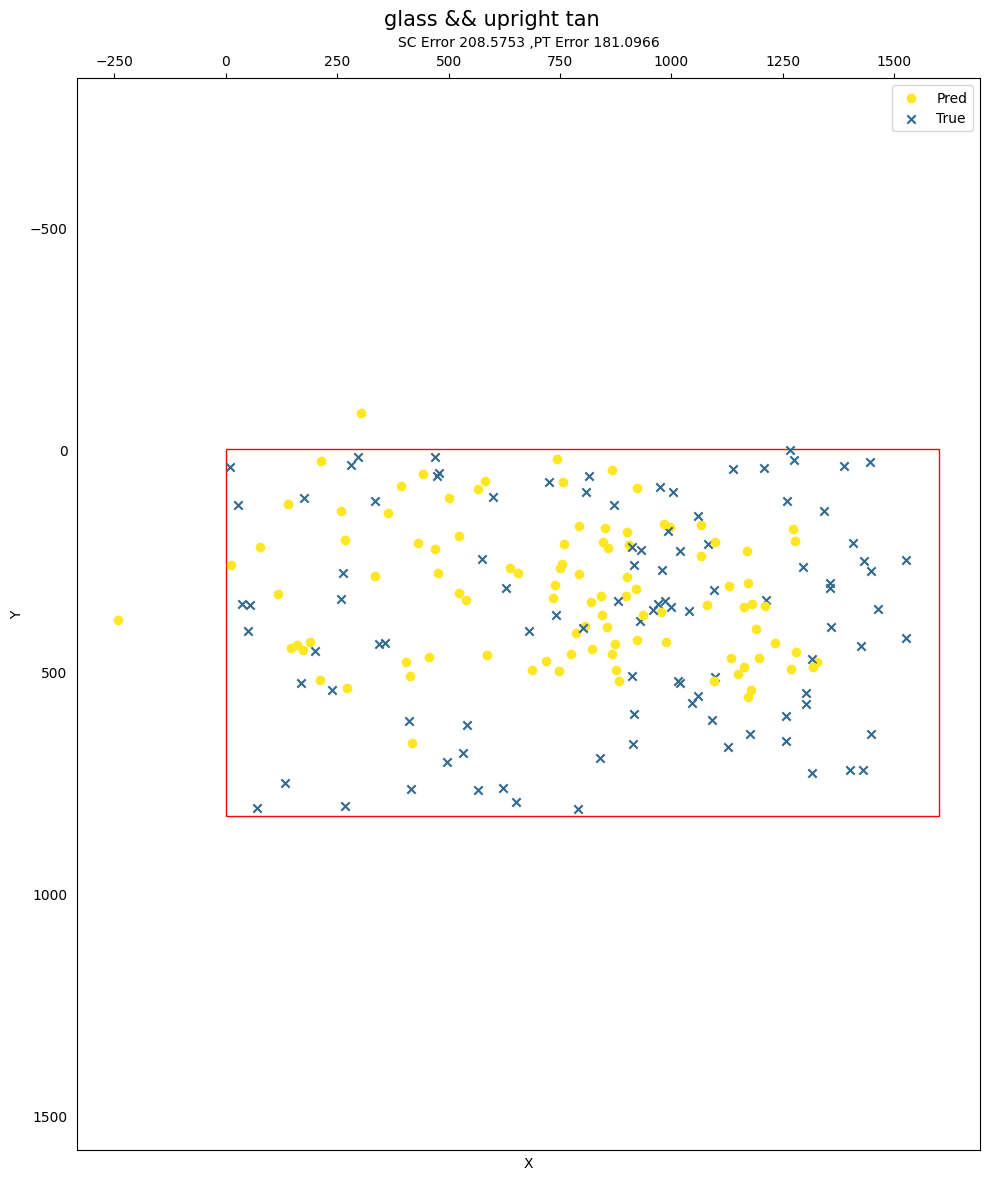

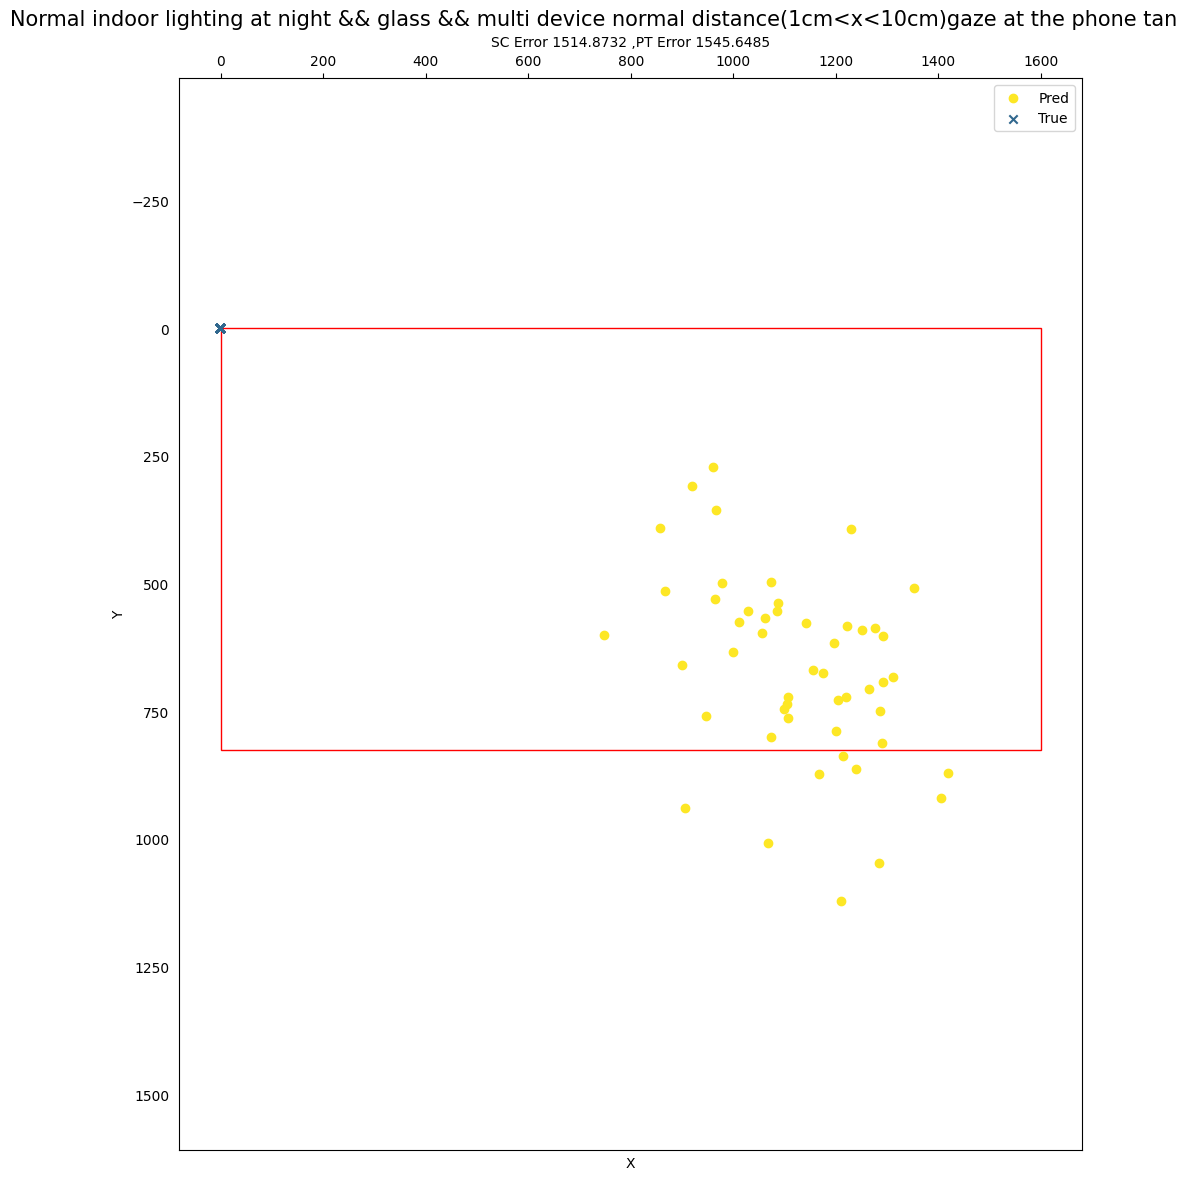

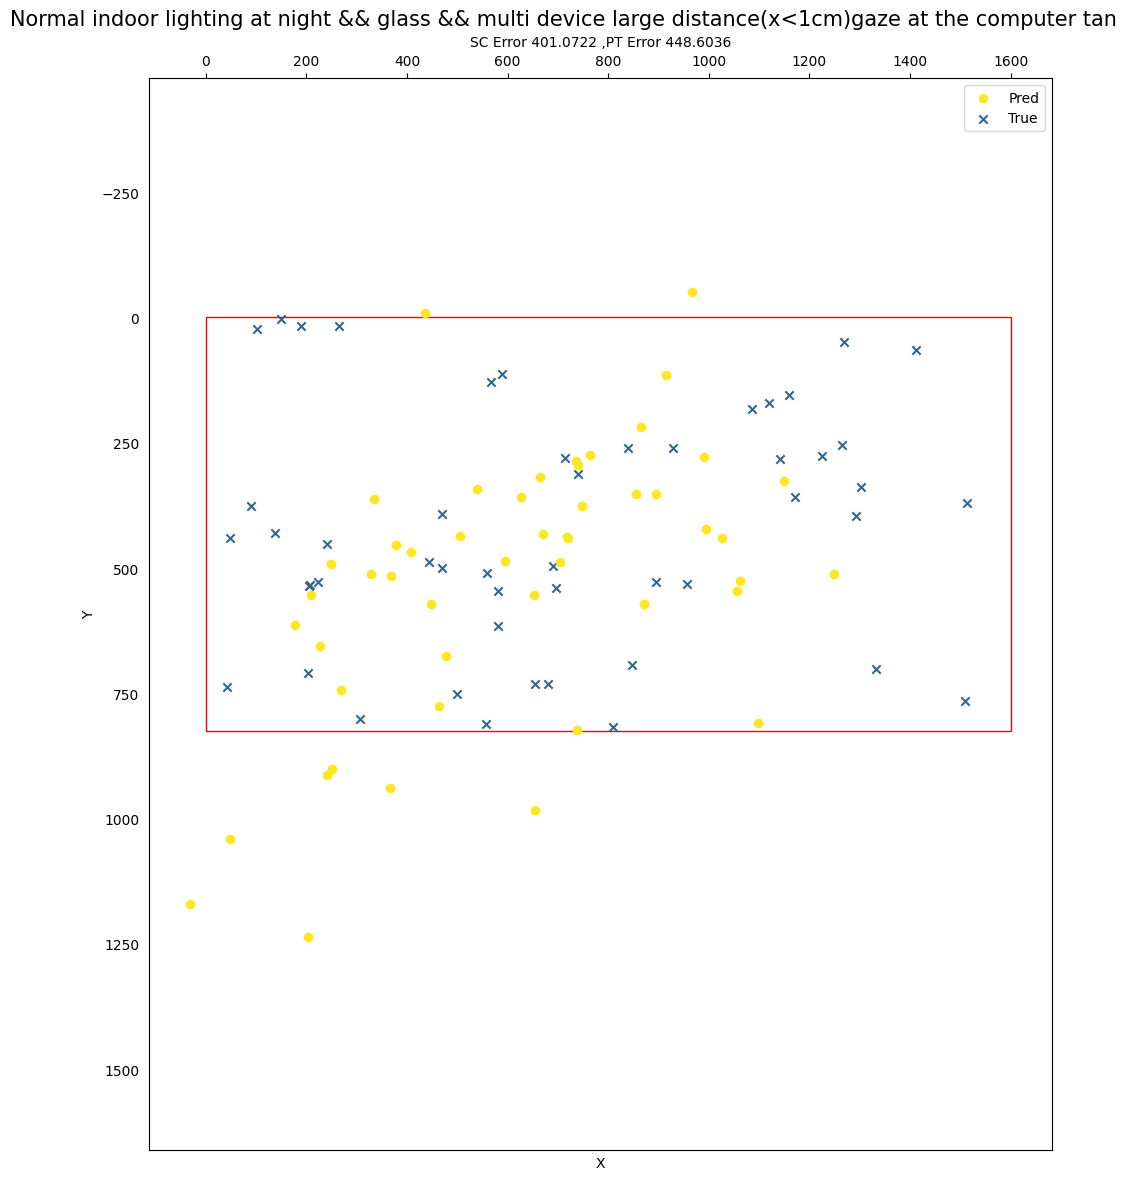

In [70]:
print(np.mean(pred_gc_org[0][:][0]))
print(np.mean(pred_gc_org[0][:][1]))
for i in [0, 19*2, 20*2]:
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot()
    if i%2==0:
        rect = plt.Rectangle((0, 0), 1600, 825, edgecolor='r', facecolor='None')
    else:
        rect = plt.Rectangle((0, 0), 1300, 720, edgecolor='r', facecolor='None')
    ax.add_patch(rect)
    for j in range(len(pred[i])):
        plt.scatter(pred_gc_org[i][j][0], pred_gc_org[i][j][1], marker='o', color=colors[3], label=f'Pred')
        # plt.scatter(pred_gc_org[i][j][0]-(np.mean(pred_gc_org[i][:][0])-np.mean(pred_gc_org[0][:][0])), pred_gc_org[i][j][1]-(np.mean(pred_gc_org[i][:][1])-np.mean(pred_gc_org[0][:][1])), marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(refine_pred[i][j][0], refine_pred[i][j][1], marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(final_pred[i][j][0], final_pred[i][j][1], marker='o',color = colors[2], label=f'PT Pred')
        plt.scatter(ground_truth[i][j][0], ground_truth[i][j][1], marker='x',color = colors[1], label=f'True')
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], refine_pred[i][j][0] - ground_truth[i][j][0], refine_pred[i][j][1] - ground_truth[i][j][1], color=colors[0], alpha=0.5)
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], final_pred[i][j][0] - ground_truth[i][j][0], final_pred[i][j][1] - ground_truth[i][j][1], color=colors[2], alpha=0.5)
        if (j == 0):
            plt.legend()
    plt.title(f'SC Error {SC_errors[i]:.4f} ,PT Error {PT_errors[i]:.4f}', fontsize=10)
    plt.suptitle(f'{condition_label[i]} ', fontsize=15)
    # 将x坐标轴放在上方
    plt.tick_params(axis='both', which='both', bottom=False, top=True, left=False, right=False)
    plt.gca().xaxis.set_ticks_position('top')
    plt.axis('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.legend()
    plt.tight_layout()
    # 将坐标原点设置在左上角
    plt.gca().invert_yaxis()
    plt.show()

In [64]:
com_tan = []
phone_tan = []
for j in range(50):
    if (1000.0 <= pred_gc_org[34][j][0] <= 1500.0):
        com_tan.append(j+2001)
for j in range(50):
    if (1000.0<= pred_gc_org[36][j][0] <= 1500.0):
        phone_tan.append(j+2101)
print(com_tan)
print(phone_tan)

IndexError: index 20 is out of bounds for axis 0 with size 20

In [ ]:
for j in com_tan:
    print(pred_gc_org[34][j-2001][0])

1047.964615890141
1397.008445481128
1169.6446983693254
1177.9193071473026
1222.3008023755538
1238.8269565164146
1249.7072995750696
1287.9815447853505
1203.781039907051
1157.8039832901884
1082.1871228085292
1053.050869980796
1034.2565410287764
1112.5856156385614
1027.2001250849382
1163.3989108630708
1199.9637756859247
1066.045126148233
1031.5899886427749
1051.1405406716017
1034.1565363865818
1486.5243135712576
1172.353924630598
1088.4001467228363
1392.464882527156


In [ ]:
with open('./tan_face_data_inscreen.pkl', 'rb') as file:
    tan_face_inscreen = pickle.load(file)
with open('./tan_face_data_outscreen.pkl', 'rb') as file:
    tan_face_outscreen = pickle.load(file)


FileNotFoundError: [Errno 2] No such file or directory: './tan_face_data_inscreen.pkl'

In [ ]:
tan_face_outscreen = np.asarray(tan_face_outscreen).reshape(50,3)
tan_face_inscreen = np.asarray(tan_face_inscreen).reshape(50,3)

for outscreen, inscreen in zip(tan_face_outscreen,tan_face_inscreen):
    print(outscreen, inscreen)
    print(np.linalg.norm(outscreen),np.linalg.norm(inscreen))
    print('---')

[-156.932085    -76.20732853  396.96600638] [-136.58849637  -67.92425668  347.86998824]
433.6095553011622 379.84687796873055
---
[-159.23243052  -80.08088385  387.71974203] [-134.26739985  -71.79383413  321.29700566]
426.72533700920394 355.5472614593996
---
[-155.42916234  -75.16713918  387.42836218] [-192.91324964  -86.22671906  482.51407277]
424.1568803400013 526.7545912349241
---
[-153.75757409  -74.5839002   388.47478691] [-153.33392536  -73.87833505  394.46900946]
424.4017080808444 429.6220437530454
---
[-152.24555628  -74.00985842  381.74264438] [-148.6908612   -72.27393505  381.593005  ]
417.59264251752177 415.86742521741826
---
[-154.1153647   -75.01644115  385.93642604] [-187.17532817  -85.79128201  464.4412935 ]
422.2865579509208 508.0358871657047
---
[-151.82985244  -73.88256915  382.1668056 ] [-150.22965904  -72.13340619  383.01008161]
417.80666033444834 417.69474662574817
---
[-153.06223685  -75.34040119  383.04800149] [-137.19735285  -88.13370727  381.9058605 ]
419.320874

In [ ]:
for j in com_tan:
    print(tan_face_inscreen[j-2001],np.linalg.norm(tan_face_inscreen[j-2001]))

[-142.48601748  -91.04425753  386.57077832] 421.93398613599135
[-148.50766517  -75.48623555  388.60500359] 422.80793179549346
[-155.09171619  -81.38380681  407.91013177] 443.9227861258782
[-148.82064811  -72.19223416  389.73053015] 423.3783061392188
[-139.82278854  -90.024596    389.24475679] 423.2804280462285
[-141.05054015  -91.39665754  389.80048997] 424.49149092618734
[-139.05889608  -89.16653957  387.15842619] 420.92718530792143
[-162.16990427  -85.45880782  390.27092789] 431.177089887971
[-134.41701257  -80.94495267  348.49426851] 382.18879341728916
[-146.24536543  -80.90222903  359.7189868 ] 396.6492493810264


In [ ]:
for j in phone_tan:
    print(tan_face_outscreen[j-2101],np.linalg.norm(tan_face_outscreen[j-2101]))

[-156.932085    -76.20732853  396.96600638] 433.6095553011622
[-155.42916234  -75.16713918  387.42836218] 424.1568803400013
[-152.24555628  -74.00985842  381.74264438] 417.59264251752177
[-154.1153647   -75.01644115  385.93642604] 422.2865579509208
[-151.82985244  -73.88256915  382.1668056 ] 417.80666033444834
[-153.06223685  -75.34040119  383.04800149] 419.32087456138777
[-150.66100024  -73.5236172   377.69886615] 413.2322504055045
[-146.60202645  -71.45646723  371.5307233 ] 405.7502424230359
[-144.39185987  -69.58700484  366.9619173 ] 400.44026918401494
[-149.29721037  -72.33390182  377.94350532] 412.75070392032944
[-146.33667226  -71.00216338  370.21835654] 404.37279874879505
[-143.4770574   -68.32937773  367.37173158] 400.2706072466185
[-147.58989009  -71.79994155  371.34344827] 405.9974924036406
[-150.62626365  -73.02288868  381.01763253] 416.1670936919581
[-148.63670255  -72.31533204  372.861551  ] 407.8579566548234
[-149.51535844  -73.46730246  371.70700689] 407.3308064796226
[-

In [ ]:
tan_inscreen_face_len = np.linalg.norm(tan_face_inscreen, axis=1)
tan_outscreen_face_len = np.linalg.norm(tan_face_outscreen, axis=1)

In [ ]:
com_tan = [x - 2001 for x in com_tan]
phone_tan = [x - 2101 for x in phone_tan]

In [ ]:
pred_gc_inscreen_test = []
pred_gc_outscreen_test = []
for j in range(len(pred[34])):
        pred_gc_inscreen_test.append(warp_norm.vector_to_gc(org_pred[34][j], pixel_scale_tan, tan_inscreen_face_len[j]))
for j in range(len(pred[36])):
        pred_gc_outscreen_test.append(warp_norm.vector_to_gc(org_pred[36][j], pixel_scale_tan, tan_outscreen_face_len[j]))
pred_gc_inscreen_test += org_tan
pred_gc_outscreen_test += org_tan

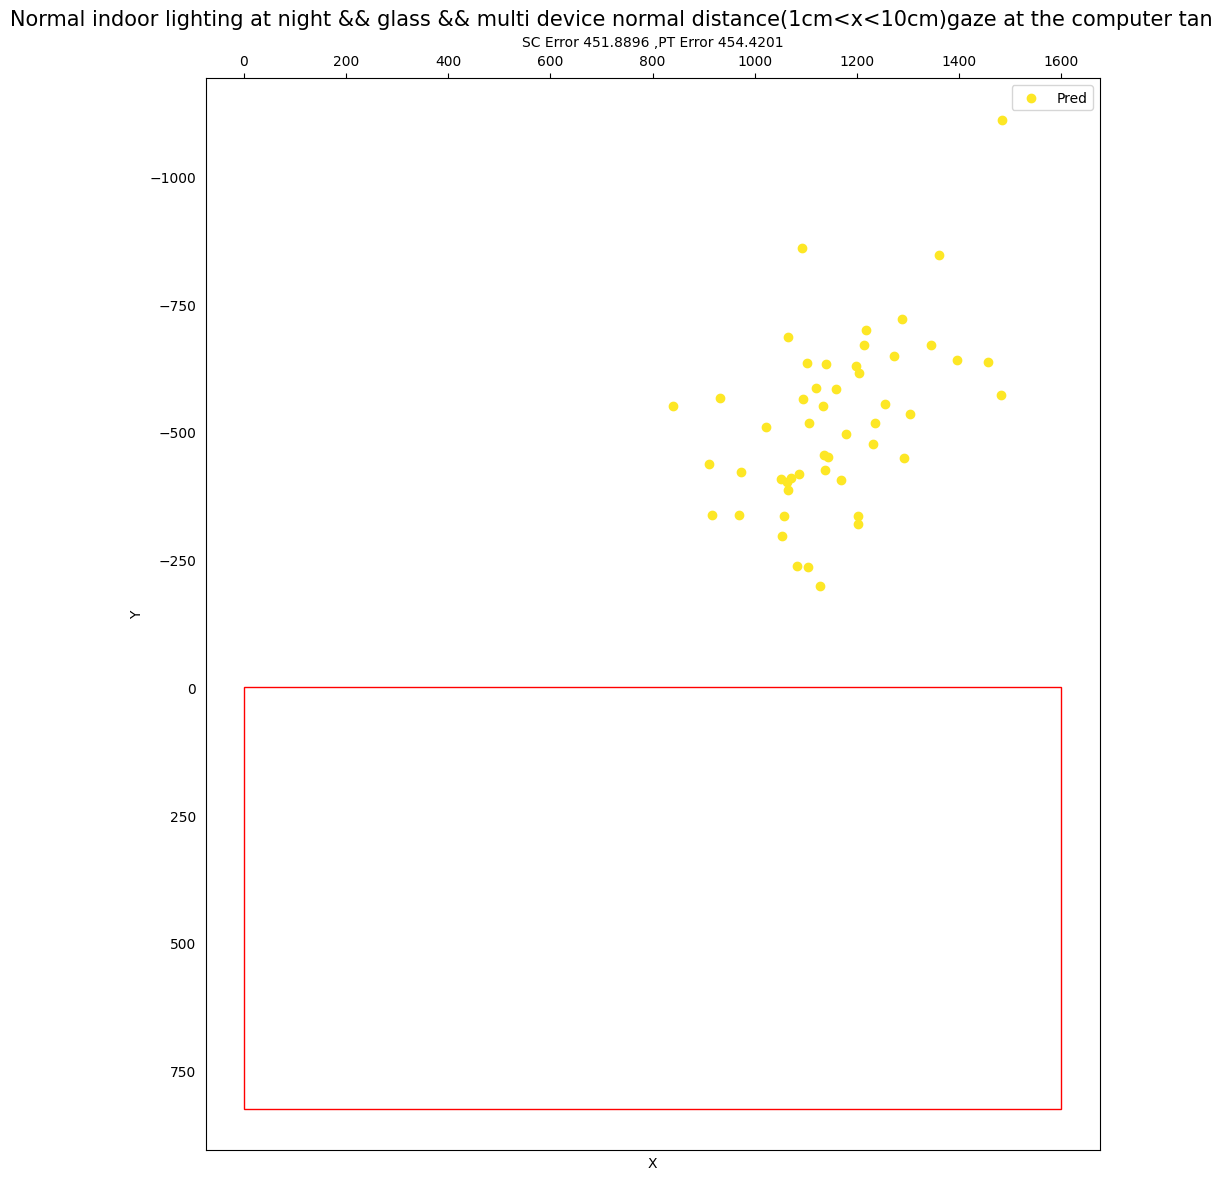

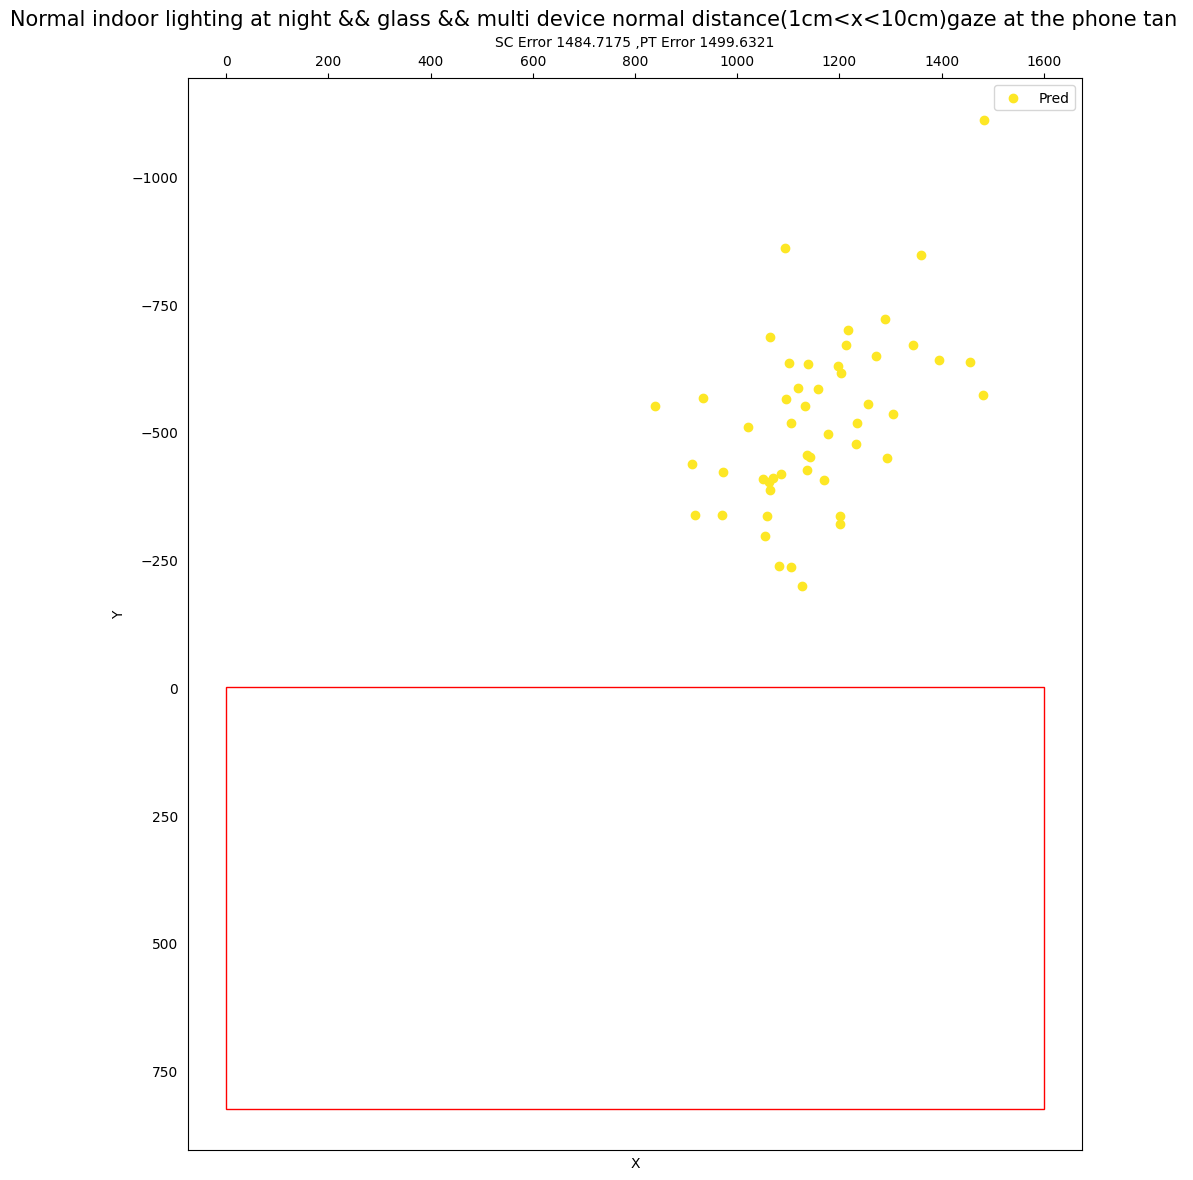

In [ ]:
for i in [17*2, 18*2]:
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot()
    if i%2==0:
        rect = plt.Rectangle((0, 0), 1600, 825, edgecolor='r', facecolor='None')
    else:
        rect = plt.Rectangle((0, 0), 1300, 720, edgecolor='r', facecolor='None')
    ax.add_patch(rect)
    for j in range(len(pred[i])):
        plt.scatter(pred_gc_outscreen_test[j][0], pred_gc_outscreen_test[j][1], marker='o', color=colors[3], label=f'Pred')
        #plt.scatter(pred_gc_org[i][j][0]-(np.mean(pred_gc_org[i][:][0])-np.mean(pred_gc_org[0][:][0])), pred_gc_org[i][j][1]-(np.mean(pred_gc_org[i][:][1])-np.mean(pred_gc_org[0][:][1])), marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(refine_pred[i][j][0], refine_pred[i][j][1], marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(final_pred[i][j][0], final_pred[i][j][1], marker='o',color = colors[2], label=f'PT Pred')
        #plt.scatter(ground_truth[i][j][0], ground_truth[i][j][1], marker='x',color = colors[1], label=f'True')
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], refine_pred[i][j][0] - ground_truth[i][j][0], refine_pred[i][j][1] - ground_truth[i][j][1], color=colors[0], alpha=0.5)
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], final_pred[i][j][0] - ground_truth[i][j][0], final_pred[i][j][1] - ground_truth[i][j][1], color=colors[2], alpha=0.5)
        if (j == 0):
            plt.legend()
    plt.title(f'SC Error {SC_errors[i]:.4f} ,PT Error {PT_errors[i]:.4f}', fontsize=10)
    plt.suptitle(f'{condition_label[i]} ', fontsize=15)
    # 将x坐标轴放在上方
    plt.tick_params(axis='both', which='both', bottom=False, top=True, left=False, right=False)
    plt.gca().xaxis.set_ticks_position('top')
    plt.axis('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.legend()
    plt.tight_layout()
    # 将坐标原点设置在左上角
    plt.gca().invert_yaxis()
    plt.show()

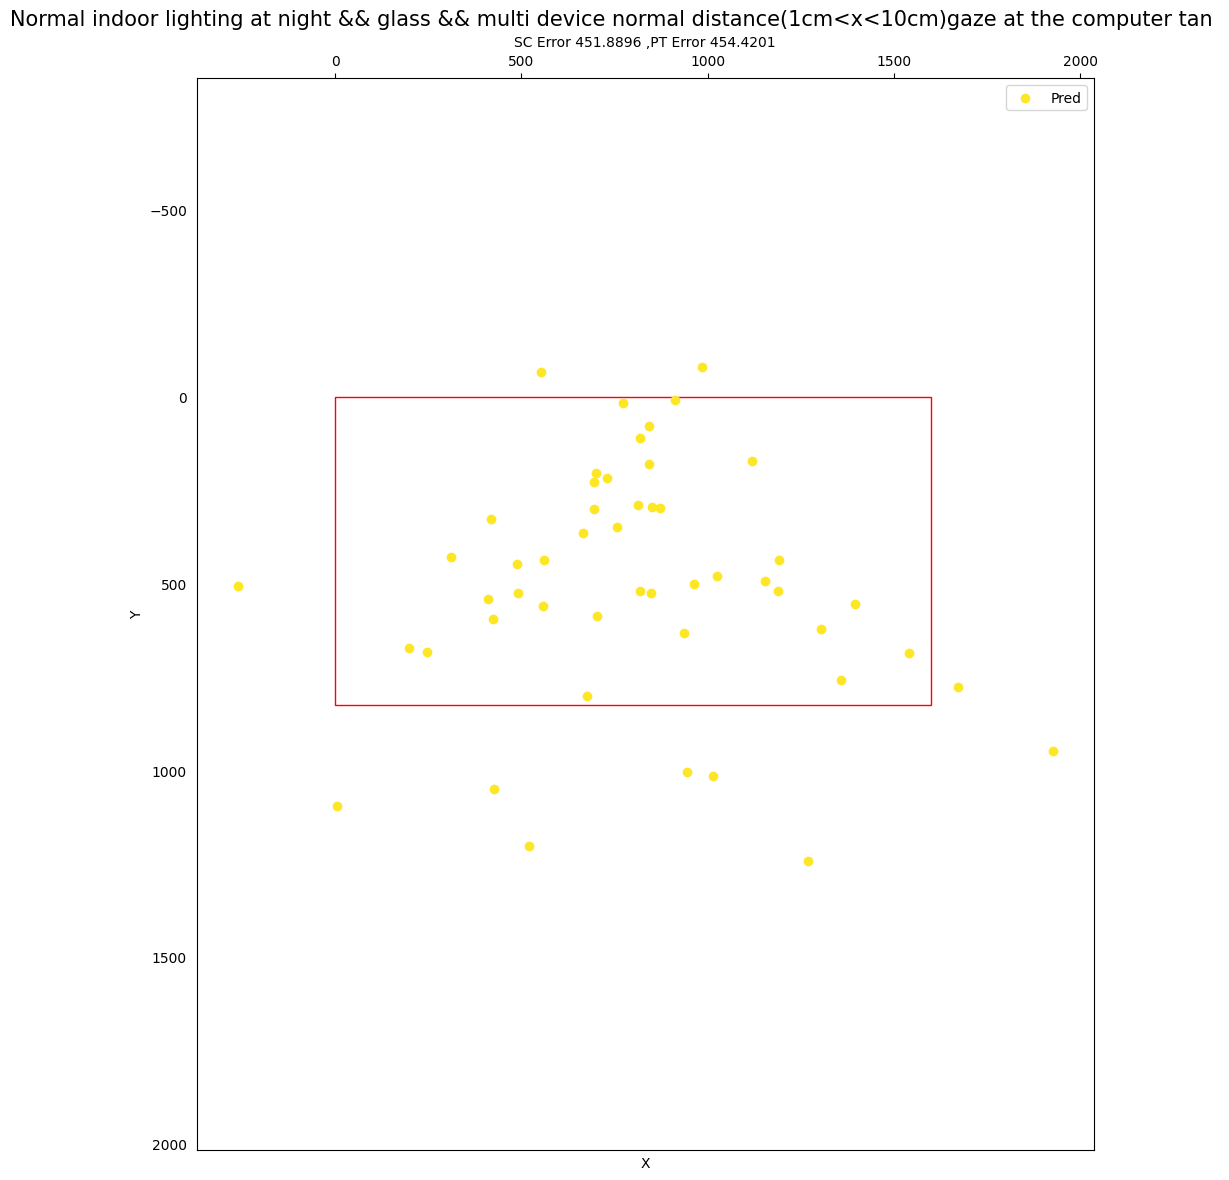

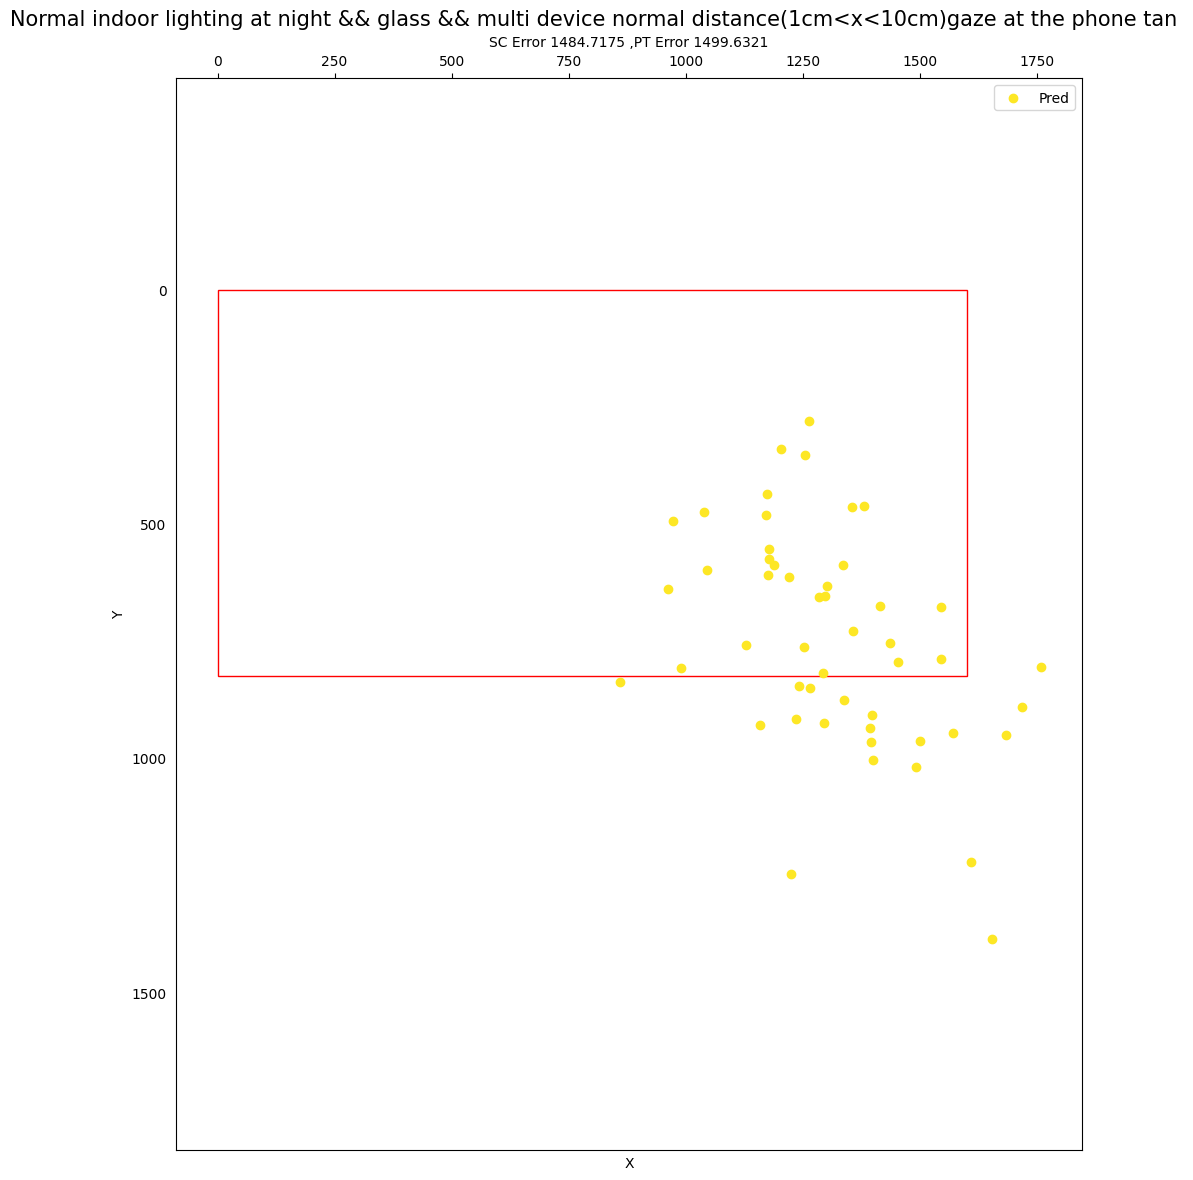

In [ ]:
for i in [17*2, 18*2]:
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot()
    if i%2==0:
        rect = plt.Rectangle((0, 0), 1600, 825, edgecolor='r', facecolor='None')
    else:
        rect = plt.Rectangle((0, 0), 1300, 720, edgecolor='r', facecolor='None')
    ax.add_patch(rect)
    for j in range(len(pred[i])):
        plt.scatter(pred_gc_org[i][j][0], pred_gc_org[i][j][1], marker='o', color=colors[3], label=f'Pred')
        #plt.scatter(pred_gc_org[i][j][0]-(np.mean(pred_gc_org[i][:][0])-np.mean(pred_gc_org[0][:][0])), pred_gc_org[i][j][1]-(np.mean(pred_gc_org[i][:][1])-np.mean(pred_gc_org[0][:][1])), marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(refine_pred[i][j][0], refine_pred[i][j][1], marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(final_pred[i][j][0], final_pred[i][j][1], marker='o',color = colors[2], label=f'PT Pred')
        #plt.scatter(ground_truth[i][j][0], ground_truth[i][j][1], marker='x',color = colors[1], label=f'True')
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], refine_pred[i][j][0] - ground_truth[i][j][0], refine_pred[i][j][1] - ground_truth[i][j][1], color=colors[0], alpha=0.5)
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], final_pred[i][j][0] - ground_truth[i][j][0], final_pred[i][j][1] - ground_truth[i][j][1], color=colors[2], alpha=0.5)
        if (j == 0):
            plt.legend()
    plt.title(f'SC Error {SC_errors[i]:.4f} ,PT Error {PT_errors[i]:.4f}', fontsize=10)
    plt.suptitle(f'{condition_label[i]} ', fontsize=15)
    # 将x坐标轴放在上方
    plt.tick_params(axis='both', which='both', bottom=False, top=True, left=False, right=False)
    plt.gca().xaxis.set_ticks_position('top')
    plt.axis('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.legend()
    plt.tight_layout()
    # 将坐标原点设置在左上角
    plt.gca().invert_yaxis()
    plt.show()

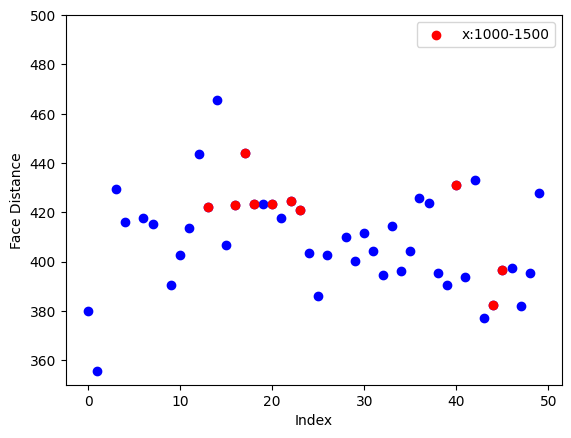

In [ ]:
plt.scatter(range(len(tan_inscreen_face_len)), tan_inscreen_face_len, c='blue')
plt.scatter(com_tan, tan_inscreen_face_len[com_tan], c='red', label='x:1000-1500')
plt.xlabel('Index')
plt.ylabel('Face Distance')
plt.ylim((350,500))
plt.legend()
plt.show()

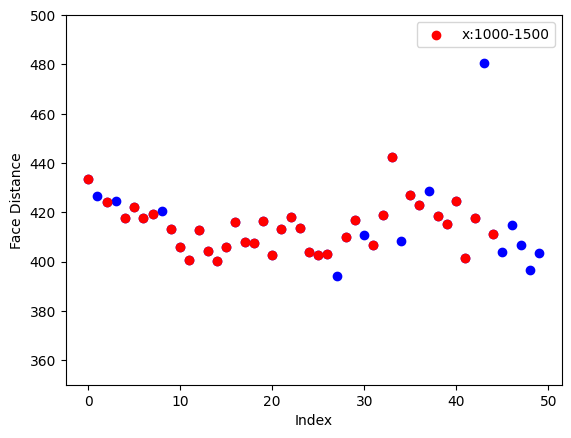

In [ ]:
plt.scatter(range(len(tan_outscreen_face_len)), tan_outscreen_face_len, c='blue')
plt.scatter(phone_tan, tan_outscreen_face_len[phone_tan], c='red', label='x:1000-1500')
plt.xlabel('Index')
plt.ylabel('Face Distance')
plt.ylim((350,500))
plt.legend()
plt.show()

In [ ]:
with open('./eve_face.pkl', 'rb') as file:
    eve_face = pickle.load(file)
eve_face = np.asarray(eve_face).reshape(-1,3)

for face in eve_face:
    print(face,np.linalg.norm(face))

[ 14.36991374   5.84030229 578.8269222 ] 579.0347221117108
[ 14.22434083   5.75665485 577.72674744] 577.9305024390062
[ 14.01828251   5.42543408 572.39453996] 572.5918764316945
[ 14.30022112   5.35681083 578.08718726] 578.2888446312305
[ 14.27712952   5.24600602 574.6127082 ] 574.8139885442791
[ 14.38086095   5.07221888 576.52733911] 576.7289738800924
[ 14.40413346   4.80505161 577.02945051] 577.2292043340185
[ 14.49761508   4.87789393 577.80399485] 578.0064283025798
[ 14.49773668   4.47387509 577.8119301 ] 578.0110954775162
[ 14.23892176   4.45009414 575.48677031] 575.680096091427
[ 13.82273002   4.17689441 575.19316515] 575.3743925071803
[ 13.71805621   4.19083581 576.33569069] 576.5141598732522
[ 13.56740066   4.0021611  578.07432174] 578.2473632541511
[ 13.57462079   4.05235026 576.04519429] 576.2193659838239
[ 13.4746243    4.16691468 580.67843368] 580.8496982990083
[ 13.50178697   4.14736764 578.6683828 ] 578.84073470897
[ 13.61381092   4.13828226 577.71154731] 577.8867476644538


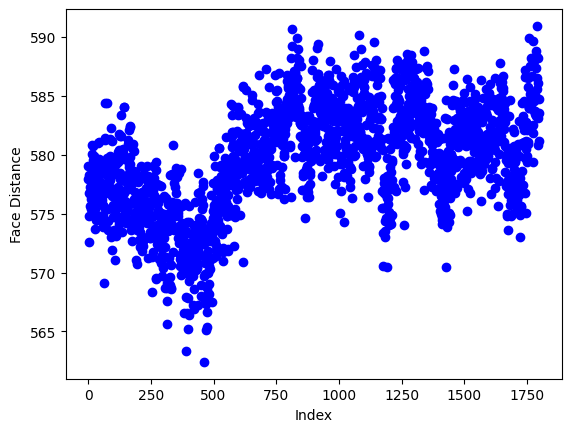

In [ ]:
eve_face_len = np.linalg.norm(eve_face, axis=1)
plt.scatter(range(len(eve_face_len)), eve_face_len, c='blue')
plt.xlabel('Index')
plt.ylabel('Face Distance')
# plt.legend()
plt.show()